In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import tensorflow as tf
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_path = '/kaggle/input/wider-face-a-face-detection-dataset/' 
EPOCHS = 20

2025-08-07 07:57:51.532435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754553471.762901      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754553471.831233      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def build_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'mae'])
    model.summary()
    return model

In [3]:
def load_wider_face_data(dataset_path, max_samples=10000):
    images = []
    labels = []
    annotation_file = os.path.join(dataset_path, 'wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt')
    image_base_path = os.path.join(dataset_path, 'WIDER_train/WIDER_train/images')
    
    if not os.path.exists(annotation_file):
        print(f"Error: Annotation file not found at {annotation_file}")
        return np.array([]), np.array([])
    
    current_image = None
    box = []
    with open(annotation_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.endswith('.jpg'): 
                if current_image and box and len(images) < max_samples:
                    img_path = os.path.join(image_base_path, current_image)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Warning: Could not load image {img_path}")
                        box = []
                        continue
                    img_pil = Image.fromarray(img)
                    
                    #Extract faces
                    for b in box:
                        x, y, w, h = b
                        if w > 0 and h > 0:
                            face = img_pil.crop((x, y, x+w, y+h))
                            face = face.resize((128, 128), Image.Resampling.LANCZOS)
                            face = np.array(face) / 255.0
                            images.append(face.reshape(128, 128, 1))
                            labels.append(1) 
                            
                            #Generate non-face patch
                            max_attempts = 10
                            for _ in range(max_attempts):
                                nx = random.randint(0, img.shape[1] - 128)
                                ny = random.randint(0, img.shape[0] - 128)
                                # Check if non-face patch intersects face
                                overlap = False
                                for bx, by, bw, bh in box:
                                    if (nx < bx + bw and nx + 128 > bx and ny < by + bh and ny + 128 > by):
                                        overlap = True
                                        break
                                if not overlap:
                                    non_face = img_pil.crop((nx, ny, nx+128, ny+128))
                                    non_face = np.array(non_face) / 255.0
                                    images.append(non_face.reshape(128, 128, 1))
                                    labels.append(0)
                                    break
                current_image = line
                box = []
            #To calculate no. of faces
            elif line.isdigit():
                continue
            else:
                parts = line.split()
                if len(parts) >= 4:
                    x, y, w, h = map(int, parts[:4])
                    box.append((x, y, w, h))
    
    return np.array(images), np.array(labels)

I0000 00:00:1754553485.416668      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754553485.417441      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1754553495.980742      99 service.cc:148] XLA service 0x7a5224005590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754553495.981625      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754553495.981644      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754553496.322988      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/258 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5124 - loss: 0.7270 - mae: 0.4809

I0000 00:00:1754553499.575546      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8395 - loss: 0.3766 - mae: 0.2369
Epoch 1: val_loss improved from inf to 0.13682, saving model to facedetectortask2.weights.h5
258/258 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8398 - loss: 0.3762 - mae: 0.2367 - val_accuracy: 0.9563 - val_loss: 0.1368 - val_mae: 0.0847 - learning_rate: 0.0010
Epoch 2/20
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9544 - loss: 0.1612 - mae: 0.0846
Epoch 2: val_loss improved from 0.13682 to 0.11388, saving model to facedetectortask2.weights.h5
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9544 - loss: 0.1612 - mae: 0.0846 - val_accuracy: 0.9587 - val_loss: 0.1139 - val_mae: 0.0588 - learning_rate: 9.0000e-04
Epoch 3/20
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9634 - loss: 0.1235 - mae: 0.0662
Epoch 3: val_loss improved from 0.11388 to 0.06614, saving model to facedetectortask2.weights.h5
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9634 - loss:

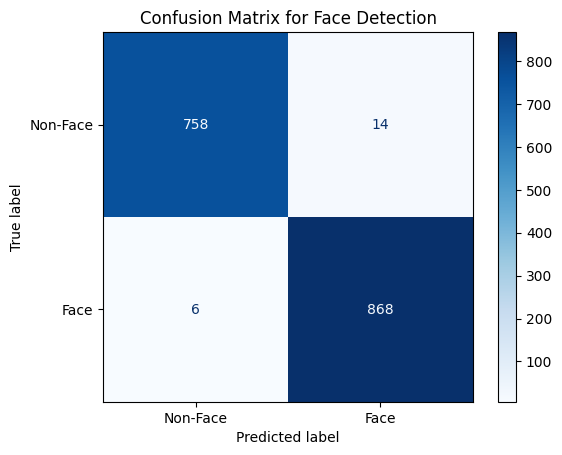

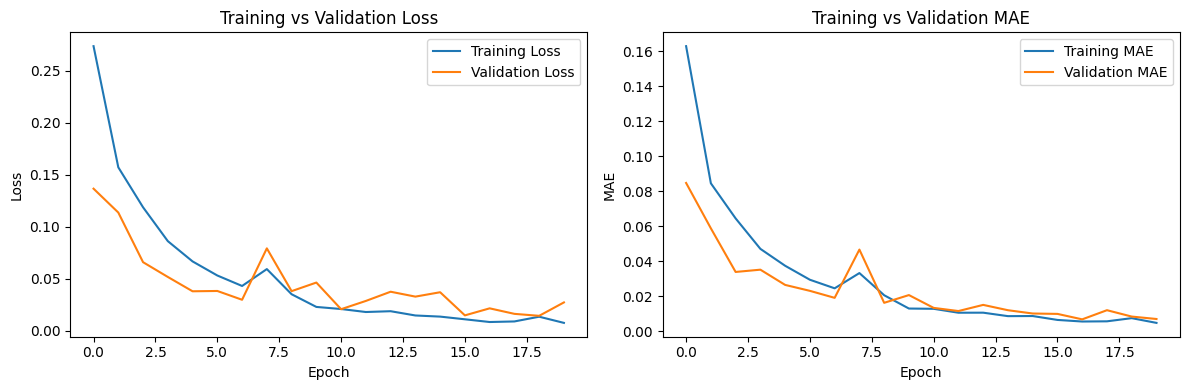

In [4]:
model = build_model()
x, y = load_wider_face_data(dataset_path)
x_train, x_tt, y_train, y_tt = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_tt, y_tt, test_size=0.2, random_state=42)

checkpoint = ModelCheckpoint(
    'facedetectortask2.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

annealer = LearningRateScheduler(lambda z: 1e-3 * 0.9 ** z)
history = model.fit(x_train, y_train, 
                   epochs=EPOCHS, 
                   batch_size=32, 
                   validation_data=(x_val, y_val),
                   callbacks=[annealer, checkpoint, early_stopping],
                   verbose=1)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

model.load_weights('facedetectortask2.weights.h5')
test_loss, test_accuracy, test_mae = model.evaluate(x_test, y_test, verbose=1)
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  
y_test_classes = y_test

precision = precision_score(y_test_classes, y_pred_classes, average='binary')
recall = recall_score(y_test_classes, y_pred_classes, average='binary')
f1 = f1_score(y_test_classes, y_pred_classes, average='binary')

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test_classes, y_pred_classes)
class_labels = ['Non-Face', 'Face']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Face Detection')
plt.show()

model.save('facedetectortask2.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()